# 주요 질병 사망자 및 보건 환경 비교 분석
## - 6 - 종합 및 결론
(Comparative Analysis of Major Disease Deaths and Health Environment)
## 1. 소개
국가별 의료 관련 데이터들을 이용해, 국가별, 연간 질병 사망자 수와 의료 인프라 간의 관계를 분석해보고 시각화를 해본 프로젝트

## 2. 목표
- 각 데이터의 EDA와 시각화
- 비슷한 분류의 데이터를 하나로 합치기
- 의료 인프라와 질병 사망자 수 관계 찾기 및 분석

## 3. 데이터 셋
- [KOSIS 10만명당 주요사망원인별 사망률](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC13&conn_path=I2)
- [KOSIS 의료종사자수](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC01&conn_path=I2)
- [KOSIS 보건관련 지출비](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC09&conn_path=I2)
- [KOSIS 보건서비스 지출비](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC14&conn_path=I2)
- [KOSIS 의약품 판매](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC25&conn_path=I2)
- [KOSIS 의약품 소비](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC24&conn_path=I2)
- [KOSIS 공공사회복지 지출](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAD21&conn_path=I2)
- [geojson 데이터](https://github.com/dr5hn/countries-states-cities-database/blob/master/countries.json)

## 4. 구현

#### 라이브러리

In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import cufflinks as cf
import chart_studio
import folium
from folium.plugins import MarkerCluster
import json

#### 한글 폰트 설정

In [2]:
from IPython.display import set_matplotlib_formats

def get_font_family():
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

get_font_family()

plt.style.use("ggplot")

font_family = get_font_family()
plt.rc("font", family=font_family)
plt.rc("axes", unicode_minus=False)

set_matplotlib_formats("retina")

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: ca

In [3]:
# 모든 데이터 공통 국가
country_intersection = ['룩셈부르크',  '네덜란드',  '영국',  '이탈리아',  '캐나다',  '오스트레일리아',  '한국',  '일본',  '스페인',  '헝가리',  '독일',  '에스토니아',  '그리스',  '슬로바키아',  '핀란드',  '벨기에',  '체코',  '슬로베니아',  '프랑스',  '스웨덴',  '노르웨이',  '뉴질랜드',  '라트비아',  '덴마크',  '오스트리아',  '포르투갈',  '아일랜드',  '아이슬란드']

#### Data Load
각 파트별로 EDA 및 시각화를 진행한 후, 최종적으로 전처리된 파일은 6개입니다.  
**종합 및 결론**에서 사용하는 데이터 파일은 다음과 같이 총 8개 입니다.
- [KOSIS 10만명당 주요사망원인별 사망률](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC13&vw_cd=MT_RTITLE&list_id=101_003_E&seqNo=&lang_mode=ko&language=kor&obj_var_id=&itm_id=&conn_path=MT_RTITLE) → `df_death_rate`
- [KOSIS 의료종사자수](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC01&conn_path=I2) → `df_Nmw`
- [KOSIS 보건관련 지출비](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC09&conn_path=I2) → `df_service`
- [KOSIS 보건서비스 지출비](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC14&conn_path=I2) → `df_service_common`
- [KOSIS 의약품 판매](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC25&conn_path=I2) → `df_medicion`
- [KOSIS 의약품 소비](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC24&conn_path=I2) → `df_medicion`
- [KOSIS 공공사회복지 지출](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAD21&conn_path=I2) → `df_welfare`
- [geojson 데이터](https://github.com/dr5hn/countries-states-cities-database/blob/master/countries.json) → `countries.geo.edited.json`, `countries.json`

In [4]:
df_death_rate = pd.read_csv("data/pre_df/df_death_rate.csv")
df_Nmw = pd.read_csv("data/pre_df/df_Nmw.csv")
df_service = pd.read_csv("data/pre_df/df_service.csv")
df_service_common = pd.read_csv("data/pre_df/df_service_common.csv")
df_medicion = pd.read_csv("data/pre_df/df_medicion.csv")
df_welfare = pd.read_csv("data/pre_df/df_welfare.csv")

In [5]:
# df_death_rate = pd.read_csv("https://raw.githubusercontent.com/likeleeseul/Mini_Project/main/8.%20CAoMDDaHE/data/pre_df/df_death_rate.csv")
# df_Nmw = pd.read_csv("https://raw.githubusercontent.com/likeleeseul/Mini_Project/main/8.%20CAoMDDaHE/data/pre_df/df_Nmw.csv")
# df_service = pd.read_csv("https://raw.githubusercontent.com/likeleeseul/Mini_Project/main/8.%20CAoMDDaHE/data/pre_df/df_service.csv")
# df_service_common = pd.read_csv("https://raw.githubusercontent.com/likeleeseul/Mini_Project/main/8.%20CAoMDDaHE/data/pre_df/df_service_common.csv")
# df_medicion = pd.read_csv("https://raw.githubusercontent.com/likeleeseul/Mini_Project/main/8.%20CAoMDDaHE/data/pre_df/df_medicion.csv")
# df_welfare = pd.read_csv("https://raw.githubusercontent.com/likeleeseul/Mini_Project/main/8.%20CAoMDDaHE/data/pre_df/df_welfare.csv")

In [6]:
g_p = open("data/countries.geo.edited.json")
gp = open("data/countries.json")
geo_poly = json.load(g_p)
geo_point = pd.json_normalize(json.load(gp))
g_p.close()
gp.close()

### df_welfare, df_service_common 수정사항 공유 (csv 파일 다시 공유드린 후에 지워주시면 됩니다 :) )
    1. 공공복지 (df_welfare)
        -  소계/전년대비 증감 결측치 다시 제거 (분명 지웠는데 :) 죄송합니당..)
        - 값(% of gdp)	전년대비증감	key_gdp	컬럼 제거
        - 공통 국가만 선택 후, 공통국가여부 컬럼 삭제 

    2. 사회복지서비스 (df_service_common)
        - 전년대비 증감에 결측치 존재 (얘도 분명 지웠는데..) : 안 씀 -> 삭제
        - '값(백만 자국화폐)', 'key_currency_x', 'key_currency_ext', '환율
        (자국화폐단위/$)'컬럼 제거
        - 공통 국가만 선택 후, 공통국가여부 컬럼 삭제

            -> 데이터셋 다시 저장해서 공유! 

In [7]:
# 사회복지 서비스
# 결측치 제거 위해, 전년대비 증감 불필요한 컬럼 제거
df_service_common = df_service_common.drop('전년대비증감', axis = 1)
# '값(백만 자국화폐)', 'key_currency_x', 'key_currency_ext', '환율(자국화폐단위/$)' 컬럼 삭제
df_service_common = df_service_common.drop(['값(백만 자국화폐)', 'key_currency_x', 'key_currency_ext', '환율(자국화폐단위/$)'], axis = 1)
df_service_common = df_service_common.drop('공통국가여부', axis = 1)
df_service_common.isnull().sum()


대륙            0
국가            0
항목구분          0
연도            0
서비스비용(백만$)    0
dtype: int64

In [8]:
# 공공사회복지지출
# 결측치 탐색 결론 :  전년대비 증감 NaN -fillna > 소계 삭제
df_welfare['전년대비증감'] = df_welfare['전년대비증감'].fillna(0)
# 결측치 2행 처리 후, 소계 마저 삭제해줌
df_welfare = df_welfare.dropna(how = 'any')
# '값(% of gdp)', '전년대비증감', 'key_gdp'  컬럼 제거
df_welfare = df_welfare.drop(['값(% of gdp)', '전년대비증감', 'key_gdp'], axis = 1)
drop_index = df_welfare[df_welfare['공통국가여부']=='해당아님'].index
df_welfare = df_welfare.drop(index = drop_index.tolist(), axis = 0)
df_welfare = df_welfare.drop('공통국가여부', axis = 1)
df_welfare.isnull().sum()


대륙            0
국가            0
연도            0
GDP(10억$)     0
복지비용(10억$)    0
dtype: int64

### 데이터 셋 EDA

In [9]:
print(f"df_death_rate: \t\t{df_death_rate.shape}\ndf_Nmw: \t\t{df_Nmw.shape}\ndf_service: \t\t{df_service.shape}\ndf_service_common: \t{df_service_common.shape}\ndf_medicion: \t\t{df_medicion.shape}\ndf_welfare: \t\t{df_welfare.shape}")

df_death_rate: 		(18507, 8)
df_Nmw: 		(1829, 7)
df_service: 		(3192, 5)
df_service_common: 	(3788, 5)
df_medicion: 		(4724, 5)
df_welfare: 		(608, 5)


In [10]:
# 파일 별 column 정보
print(f"df_death_rate: \t\t{df_death_rate.columns.values}\ndf_Nmw: \t\t{df_Nmw.columns.values}\ndf_service: \t\t{df_service.columns.values}\ndf_service_common: \t{df_service_common.columns.values}\ndf_medicion: \t\t{df_medicion.columns.values}\ndf_welfare: \t\t{df_welfare.columns.values}")

df_death_rate: 		['국가' '질병명' '연도' '성별' '사망률' '국가영문' '위도' '경도']
df_Nmw: 		['국가' '연도' '직업' '수' '국가영문' '위도' '경도']
df_service: 		['국가별' '항목' '데이터값' '연도' '국가영문']
df_service_common: 	['대륙' '국가' '항목구분' '연도' '서비스비용(백만$)']
df_medicion: 		['국가' '연도' '의약품' '의약품소비량' '의약품판매량']
df_welfare: 		['대륙' '국가' '연도' 'GDP(10억$)' '복지비용(10억$)']


In [11]:
# 전체 결측치 확인
print(f"df_death_rate: \t\t{df_death_rate.isnull().sum().sum()}\ndf_Nmw: \t\t{df_Nmw.isnull().sum().sum()}\ndf_service: \t\t{df_service.isnull().sum().sum()}\ndf_service_common: \t{df_service_common.isnull().sum().sum()}\ndf_medicion: \t\t{df_medicion.isnull().sum().sum()}\ndf_welfare: \t\t{df_welfare.isnull().sum().sum()}")

df_death_rate: 		0
df_Nmw: 		0
df_service: 		0
df_service_common: 	0
df_medicion: 		0
df_welfare: 		0


In [12]:
# 전체 중복값 확인
print(f"df_death_rate: \t\t{df_death_rate.duplicated().sum()}\ndf_Nmw: \t\t{df_Nmw.duplicated().sum()}\ndf_service: \t\t{df_service.duplicated().sum()}\ndf_service_common: \t{df_service_common.duplicated().sum()}\ndf_medicion: \t\t{df_medicion.duplicated().sum()}\ndf_welfare: \t\t{df_welfare.duplicated().sum()}")

df_death_rate: 		0
df_Nmw: 		0
df_service: 		0
df_service_common: 	0
df_medicion: 		0
df_welfare: 		0


### 통합 데이터 생성
앞서 사용한 데이터들을 집계 함수를 이용해 하나의 데이터로 생성합니다.
#### 1. 연간 평균 사망률

In [13]:
df_corr = pd.DataFrame(df_death_rate.groupby(["국가", "연도"])["사망률"].mean()).reset_index().copy()
df_corr.columns = ["국가", "연도", "평균 사망률"]
df_corr

,국가,연도,평균 사망률
0,그리스,1998,40.600000
1,그리스,1999,40.382857
2,그리스,2000,40.357143
3,그리스,2001,39.397143
4,그리스,2002,38.622857
...,...,...,...
523,헝가리,2013,56.522857
524,헝가리,2014,55.531429
525,헝가리,2015,56.282857
526,헝가리,2016,53.828571


#### 2. 평균 의료 종사자 수 : 의사/간호사 데이터 분석
치과의사와 약사의 경우 시간의 흐름과 무관하게 종사자 수가 비슷한 수준으로 유지되어 사망률에 영향을 미치지 않음을 확인했습니다.따라서 본 분석에서는 사용하지 않습니다.

In [14]:
df_Nmw = df_Nmw[df_Nmw["직업"].isin(["의사", "간호사"])].reset_index(drop=True).copy()
df_Nmw.sample(5)

,국가,연도,직업,수,국가영문,위도,경도
302,에스토니아,2016,의사,4548.0,estonia,59.00,26.000000
468,아이슬란드,1998,간호사,3701.0,iceland,65.00,-18.000000
903,오스트레일리아,2009,간호사,220814.0,australia,-27.00,133.000000
854,영국,2007,간호사,530578.0,uk,54.00,-2.000000
641,룩셈부르크,2017,의사,1780.0,luxembourg,49.75,6.166667


평균 의료 종사자 수를 구합니다

In [15]:
temp = pd.DataFrame(df_Nmw.groupby(["국가", "연도"])["수"].mean()).reset_index().copy()
temp.columns = ["국가", "연도", "평균 의료 인력 수"]
temp.sample(5)

,국가,연도,평균 의료 인력 수
284,아일랜드,2016,15178.0
194,스웨덴,2006,64347.5
259,아이슬란드,2001,2367.5
274,아이슬란드,2016,3031.0
255,슬로베니아,2019,14138.0


평균 사망률과 평균 의료 인력을 합칩니다.

In [16]:
df_corr = pd.merge(left=df_corr, right=temp, how="outer", on=["국가", "연도"]).copy()
df_corr

,국가,연도,평균 사망률,평균 의료 인력 수
0,그리스,1998,40.600000,NaN
1,그리스,1999,40.382857,28452.0
2,그리스,2000,40.357143,29704.0
3,그리스,2001,39.397143,32068.0
4,그리스,2002,38.622857,36063.0
...,...,...,...,...
603,프랑스,2016,NaN,208266.0
604,프랑스,2017,NaN,210038.0
605,프랑스,2018,NaN,210567.0
606,헝가리,2017,NaN,48141.0


#### 3. 보건 관련 지출비
나라 간의 개인 생활 수준을 비교하기엔 PPP가 적합하므로 여러 항목 중 **1인당 보건지출(PPP)(US%)** 항목만을 이용합니다

In [17]:
temp = pd.DataFrame(df_service.groupby(["국가별", "연도", "항목"])["데이터값"].mean()).reset_index()
temp

,국가별,연도,항목,데이터값
0,그리스,2000,1인당 보건지출(PPP)(US$),1417.777954
1,그리스,2000,1인당 보건지출(US$),885.410400
2,그리스,2000,경상(GDP 대비%),7.243326
3,그리스,2000,공공(경상보건비 대비%),61.626427
4,그리스,2000,본인부담(경상보건비 대비%),36.272114
...,...,...,...,...
3187,헝가리,2018,1인당 보건지출(US$),1081.802856
3188,헝가리,2018,경상(GDP 대비%),6.700072
3189,헝가리,2018,공공(경상보건비 대비%),69.100578
3190,헝가리,2018,본인부담(경상보건비 대비%),26.914713


In [18]:
temp = temp[temp["항목"]=="1인당 보건지출(PPP)(US$)"].reset_index(drop=True).copy()
temp.columns = ["국가", "연도", "항목", "1인당 보건지출"]
temp = temp[["국가", "연도", "1인당 보건지출"]].copy()
temp

,국가,연도,1인당 보건지출
0,그리스,2000,1417.777954
1,그리스,2001,1678.575684
2,그리스,2002,1864.497559
3,그리스,2003,2019.099609
4,그리스,2004,2061.648193
...,...,...,...
527,헝가리,2014,1808.397217
528,헝가리,2015,1834.953613
529,헝가리,2016,1949.052490
530,헝가리,2017,2003.747681


In [19]:
df_corr = pd.merge(left=df_corr, right=temp, how="outer", on=["국가", "연도"]).copy()
df_corr

,국가,연도,평균 사망률,평균 의료 인력 수,1인당 보건지출
0,그리스,1998,40.600000,NaN,NaN
1,그리스,1999,40.382857,28452.0,NaN
2,그리스,2000,40.357143,29704.0,1417.777954
3,그리스,2001,39.397143,32068.0,1678.575684
4,그리스,2002,38.622857,36063.0,1864.497559
...,...,...,...,...,...
620,포르투갈,2017,NaN,NaN,3084.172852
621,포르투갈,2018,NaN,NaN,3242.351807
622,핀란드,2016,NaN,NaN,4211.662109
623,핀란드,2017,NaN,NaN,4339.905762


#### 4. 의약품 판매 소비  


In [20]:
temp = pd.DataFrame(df_medicion.groupby(["국가", "연도"])[["의약품소비량", "의약품판매량"]].mean()).reset_index()
temp.columns = ["국가", "연도", "평균 소비량", "평균 판매량"]
temp

,국가,연도,평균 소비량,평균 판매량
0,그리스,1998,29.609091,2032.8
1,그리스,1999,32.909091,2366.4
2,그리스,2000,35.681818,2398.1
3,그리스,2001,37.318182,2807.4
4,그리스,2002,40.245455,3557.4
...,...,...,...,...
496,헝가리,2016,46.436364,1772.0
497,헝가리,2017,47.063636,1796.5
498,헝가리,2018,48.454545,2240.1
499,헝가리,2019,50.290909,2183.7


In [21]:
df_corr = pd.merge(left=df_corr, right=temp, how="outer", on=["국가", "연도"]).copy()
df_corr

,국가,연도,평균 사망률,평균 의료 인력 수,1인당 보건지출,평균 소비량,평균 판매량
0,그리스,1998,40.600000,NaN,NaN,29.609091,2032.8
1,그리스,1999,40.382857,28452.0,NaN,32.909091,2366.4
2,그리스,2000,40.357143,29704.0,1417.777954,35.681818,2398.1
3,그리스,2001,39.397143,32068.0,1678.575684,37.318182,2807.4
4,그리스,2002,38.622857,36063.0,1864.497559,40.245455,3557.4
...,...,...,...,...,...,...,...
649,터키,2017,NaN,NaN,NaN,52.863636,6975.5
650,터키,2018,NaN,NaN,NaN,57.981818,6635.4
651,터키,2019,NaN,NaN,NaN,58.918182,7414.8
652,포르투갈,2020,NaN,NaN,NaN,67.940000,3208.7


#### 5. 보건 서비스와 공공사회
##### 보건 서비스

In [22]:
pd.Series(df_service_common["항목구분"].unique())

0         보건 당기 지출
1       치료 및 재활 치료
2            장기 치료
3        보건 보조 서비스
4              의료품
5             예방치료
6    정부의료체계 및 재정행정
dtype: object

보건 서비스 지출 내역에서, **치료 및 재활 치료, 장기 치료, 예방치료** 항목만 사용합니다.  
보건 보조 서비스는 인력, 정부의료체계 및 재정행정은 공공사회와 연관이 있고 의료품은 앞서 데이터를 가지고 있기 때문입니다.

In [23]:
temp = df_service_common[df_service_common["항목구분"].isin(["치료 및 재활 치료", "장기 치료", "예방치료"])].reset_index(drop=True)

In [24]:
temp = temp.groupby(["국가", "연도"])[["서비스비용(백만$)"]].mean().reset_index()
temp.columns = ["국가", "연도", "평균 치료비"]
temp

,국가,연도,평균 치료비
0,그리스,2003,506.273333
1,그리스,2004,575.290000
2,그리스,2005,625.670000
3,그리스,2006,648.686667
4,그리스,2007,769.300000
...,...,...,...
537,헝가리,2015,1701.903333
538,헝가리,2016,1776.880000
539,헝가리,2017,1956.316667
540,헝가리,2018,2131.090000


In [25]:
df_corr = pd.merge(left=df_corr, right=temp, how="outer", on=["국가", "연도"]).copy()
df_corr

,국가,연도,평균 사망률,평균 의료 인력 수,1인당 보건지출,평균 소비량,평균 판매량,평균 치료비
0,그리스,1998,40.600000,NaN,NaN,29.609091,2032.8,NaN
1,그리스,1999,40.382857,28452.0,NaN,32.909091,2366.4,NaN
2,그리스,2000,40.357143,29704.0,1417.777954,35.681818,2398.1,NaN
3,그리스,2001,39.397143,32068.0,1678.575684,37.318182,2807.4,NaN
4,그리스,2002,38.622857,36063.0,1864.497559,40.245455,3557.4,NaN
...,...,...,...,...,...,...,...,...
649,터키,2017,NaN,NaN,NaN,52.863636,6975.5,NaN
650,터키,2018,NaN,NaN,NaN,57.981818,6635.4,NaN
651,터키,2019,NaN,NaN,NaN,58.918182,7414.8,NaN
652,포르투갈,2020,NaN,NaN,NaN,67.940000,3208.7,NaN


##### 공공 사회 복지 지출
`G`는 10억을 나타내는 SI 접두어 입니다.

In [26]:
temp = pd.DataFrame(df_welfare.groupby(["국가", "연도"])["복지비용(10억$)"].mean()).reset_index()
temp.columns = ["국가", "연도", "평균 복지 비용(G$)"]
temp

,국가,연도,평균 복지 비용(G$)
0,그리스,1998,2527.00
1,그리스,1999,2565.00
2,그리스,2000,2315.78
3,그리스,2001,2533.32
4,그리스,2002,2829.92
...,...,...,...
603,헝가리,2015,2552.04
604,헝가리,2016,2608.55
605,헝가리,2017,2817.10
606,헝가리,2018,3015.52


In [27]:
df_corr = pd.merge(left=df_corr, right=temp, how="outer", on=["국가", "연도"]).copy()
df_corr

,국가,연도,평균 사망률,평균 의료 인력 수,1인당 보건지출,평균 소비량,평균 판매량,평균 치료비,평균 복지 비용(G$)
0,그리스,1998,40.600000,NaN,NaN,29.609091,2032.8,NaN,2527.00
1,그리스,1999,40.382857,28452.0,NaN,32.909091,2366.4,NaN,2565.00
2,그리스,2000,40.357143,29704.0,1417.777954,35.681818,2398.1,NaN,2315.78
3,그리스,2001,39.397143,32068.0,1678.575684,37.318182,2807.4,NaN,2533.32
4,그리스,2002,38.622857,36063.0,1864.497559,40.245455,3557.4,NaN,2829.92
...,...,...,...,...,...,...,...,...,...
649,터키,2017,NaN,NaN,NaN,52.863636,6975.5,NaN,NaN
650,터키,2018,NaN,NaN,NaN,57.981818,6635.4,NaN,NaN
651,터키,2019,NaN,NaN,NaN,58.918182,7414.8,NaN,NaN
652,포르투갈,2020,NaN,NaN,NaN,67.940000,3208.7,NaN,NaN


여러 데이터의 공통 항목들로 평균 값을 담고 있는데 데이터 프레임을 생성했습니다.  
`how=inner`로 `merge`를 진행한 경우, 한쪽에서 데이터가 존재하지 않으면 생성되지 않는 문제가 있어 `outer`로 진행했습니다.

### EDA 및 시각화

#### 전처리 및 초기 분석
이미 전처리된 데이터들을 이용했지만, 혹시 모르니 한 번 더 확인해봅니다.
##### 기본 정보 확인

In [28]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 654 entries, 0 to 653
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   국가            654 non-null    object 
 1   연도            654 non-null    int64  
 2   평균 사망률        528 non-null    float64
 3   평균 의료 인력 수    534 non-null    float64
 4   1인당 보건지출      532 non-null    float64
 5   평균 소비량        501 non-null    float64
 6   평균 판매량        501 non-null    float64
 7   평균 치료비        542 non-null    float64
 8   평균 복지 비용(G$)  608 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 51.1+ KB


모든 데이터에서 공통으로 존재하는 데이터만 가져오니 데이터의 수가 급감했습니다.

##### 일부 행 제거하기
국가명이 **소계**인 데이터를 제거합니다.

In [29]:
df_corr = df_corr[~(df_corr["국가"]=="소계")].reset_index(drop=True).copy()

##### 결측치

In [30]:
df_corr.isnull().sum()

국가                0
연도                0
평균 사망률          126
평균 의료 인력 수      120
1인당 보건지출        122
평균 소비량          153
평균 판매량          153
평균 치료비          112
평균 복지 비용(G$)     46
dtype: int64

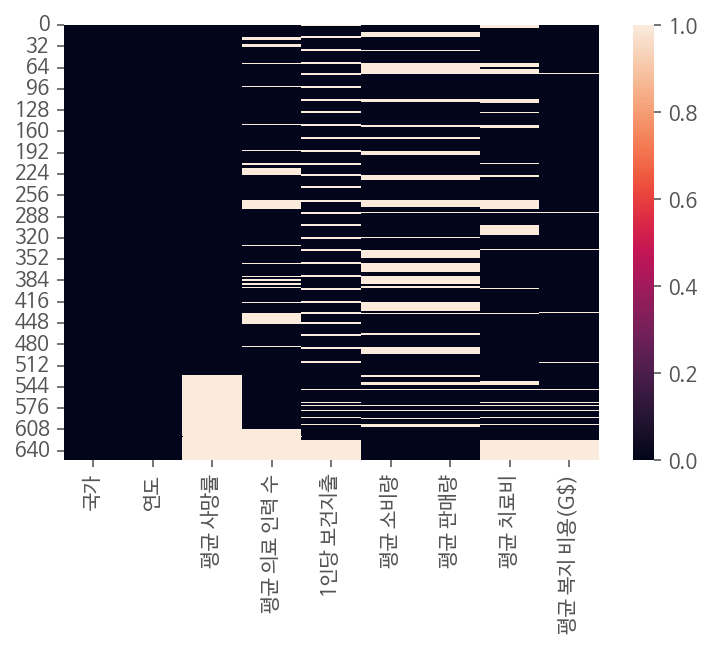

In [31]:
_ = sns.heatmap(data=df_corr.isnull())

In [32]:
df_corr.isnull().mean()*100

국가               0.000000
연도               0.000000
평균 사망률          19.266055
평균 의료 인력 수      18.348624
1인당 보건지출        18.654434
평균 소비량          23.394495
평균 판매량          23.394495
평균 치료비          17.125382
평균 복지 비용(G$)     7.033639
dtype: float64

공통 항목(국가, 연도)으로 데이터를 가져오다보니 결측치가 많습니다..  
특정 항목에 약 38% 정도 결측치가 있습니다.

##### 중복값

In [33]:
df_corr.duplicated().sum()

0

#### 기초 분석

In [34]:
# 대상 국가
for _ in [_ for _ in df_corr["국가"].unique()]:
    print(_, end=" / ")

그리스 / 네덜란드 / 노르웨이 / 뉴질랜드 / 덴마크 / 독일 / 라트비아 / 룩셈부르크 / 벨기에 / 스웨덴 / 스페인 / 슬로바키아 / 슬로베니아 / 아이슬란드 / 아일랜드 / 에스토니아 / 영국 / 오스트레일리아 / 오스트리아 / 이탈리아 / 일본 / 체코 / 캐나다 / 포르투갈 / 프랑스 / 핀란드 / 한국 / 헝가리 / 칠레 / 터키 / 

In [35]:
df_corr.describe()

,연도,평균 사망률,평균 의료 인력 수,1인당 보건지출,평균 소비량,평균 판매량,평균 치료비,평균 복지 비용(G$)
count,654.000000,528.000000,534.000000,532.000000,501.000000,501.000000,542.000000,608.000000
mean,2008.980122,37.838503,121377.060861,3128.463919,45.083475,8114.379840,10636.853020,17947.831645
std,6.521814,14.016602,163685.180910,1372.261344,13.625571,11655.894161,24306.473450,26194.829309
min,1998.000000,19.775000,1288.000000,434.380096,9.300000,60.700000,0.000000,79.230000
25%,2003.000000,28.500714,17007.250000,2100.743958,37.200000,1360.000000,467.381667,1855.095000
50%,2009.000000,33.484286,52039.500000,2978.288940,45.050000,3247.300000,1931.058333,6674.660000
75%,2015.000000,41.083571,179022.250000,4165.573608,54.750000,8458.200000,9248.685833,16060.507500
max,2020.000000,87.348571,901425.000000,6818.346191,86.777778,87553.300000,172667.636667,137090.720000


||26개국의 평균치|
|:---:|:---:|
|주요 원인별 평균 사망률|37.8%|
|평균 의료 인력 수|121377명|
|1인당 평균 보건지출|3128.4 달러|
|평균 의약품 소비량|45개|
|평균 의약품 판매량|8114.3개(연간)|
|평균 치료비|10636.8 달러|
|평균 복지 비용| 220.79 조 원|

데이터는 1998부터 2020년까지의 데이터입니다.
 

In [36]:
df_corr[df_corr["평균 의료 인력 수"]==1288]

,국가,연도,평균 사망률,평균 의료 인력 수,1인당 보건지출,평균 소비량,평균 판매량,평균 치료비,평균 복지 비용(G$)
141,룩셈부르크,2007,32.742857,1288.0,5277.879395,43.08,233.8,112.81,1028.18


In [37]:
df_corr[df_corr["평균 치료비"]==0]

,국가,연도,평균 사망률,평균 의료 인력 수,1인당 보건지출,평균 소비량,평균 판매량,평균 치료비,평균 복지 비용(G$)
212,슬로바키아,2001,68.777143,17340.0,660.651733,45.218182,344.0,0.0,529.76


In [38]:
df_corr[df_corr["평균 판매량"]==60.7]

,국가,연도,평균 사망률,평균 의료 인력 수,1인당 보건지출,평균 소비량,평균 판매량,평균 치료비,평균 복지 비용(G$)
284,에스토니아,1999,82.145714,6266.5,NaN,26.72,60.7,4.996667,88.16


In [39]:
df_corr[df_corr["평균 복지 비용(G$)"]==79.23]

,국가,연도,평균 사망률,평균 의료 인력 수,1인당 보건지출,평균 소비량,평균 판매량,평균 치료비,평균 복지 비용(G$)
285,에스토니아,2000,78.025714,6131.5,485.081024,27.57,66.4,3.966667,79.23


#### 사망률과 의료 인프라

In [40]:
df_corr.sample(5)

,국가,연도,평균 사망률,평균 의료 인력 수,1인당 보건지출,평균 소비량,평균 판매량,평균 치료비,평균 복지 비용(G$)
213,슬로바키아,2002,66.888571,17215.0,733.154663,44.772727,475.2,0.840000,607.23
560,스페인,2016,NaN,217032.0,3275.601562,70.340000,13098.0,3394.800000,29816.82
455,프랑스,2004,28.891429,193648.0,2970.663330,37.820000,28882.2,6369.783333,61143.73
121,라트비아,2006,78.308571,9580.0,899.732422,12.800000,263.1,348.216667,262.30
216,슬로바키아,2005,64.428571,NaN,1096.344727,39.763636,717.7,17.516667,960.84


In [41]:
px.line(data_frame=df_corr, x="연도", y=["평균 사망률", "평균 의료 인력 수", "1인당 보건지출", "평균 소비량", "평균 판매량", "평균 치료비", "평균 복지 비용(G$)"],\
    facet_col="국가", facet_col_wrap=6, width=1400, height=800, title="데이터 종합 (line)")

국가의 수가 많으니, 대률별로 그려보겠습니다.  
기존 데이터에 있던 대륙 정보를 이용하겠습니다.

In [42]:
temp = df_welfare[df_welfare["국가"].isin(country_intersection)][["대륙", "국가"]].drop_duplicates().reset_index(drop=True)
temp = pd.merge(left=temp, right=df_corr, on="국가", how="outer")
temp = temp[["국가", "대륙"]].drop_duplicates()

대륙 정보가 없는 경우 따로 처리를 해줬습니다.

In [43]:
asia = temp[(temp["대륙"]=="아시아") | (temp["대륙"]=="오세아니아")]["국가"].to_list()
europe = temp[temp["대륙"]=="유럽"]["국가"].to_list()
america = temp[temp["대륙"]=="북아메리카"]["국가"].to_list()

asia.extend(["터키", "이스라엘"])
europe.extend(["라투아니아", "스위스", "폴란드"])
america.extend(["칠레", "멕시코", "미국"])

개수를 확인합니다

In [44]:
df_corr["국가"].nunique() == len(asia)+len(europe)+len(america)

False

In [45]:
# 아시아
px.bar(data_frame=df_corr[df_corr["국가"].isin(asia)], x="연도", y=["평균 사망률", "평균 의료 인력 수", "1인당 보건지출", "평균 소비량", "평균 판매량", "평균 치료비", "평균 복지 비용(G$)"],\
    facet_col="국가", barmode="overlay", title="데이터 종합 (아시아 / 오세아니아)")

In [46]:
# 아메리카
px.bar(data_frame=df_corr[df_corr["국가"].isin(america)], x="연도", y=["평균 사망률", "평균 의료 인력 수", "1인당 보건지출", "평균 소비량", "평균 판매량", "평균 치료비", "평균 복지 비용(G$)"],\
    facet_col="국가", barmode="overlay", title="데이터 종합 (북미 / 남미)")

유럽은 국가가 많아 나눠 그렸습니다.

In [47]:
# 유럽
px.bar(data_frame=df_corr[df_corr["국가"].isin(europe[:10])], x="연도", y=["평균 사망률", "평균 의료 인력 수", "1인당 보건지출", "평균 소비량", "평균 판매량", "평균 치료비", "평균 복지 비용(G$)"],\
    facet_col="국가", facet_col_wrap=5, barmode="overlay", title="데이터 종합 (유럽)")

In [48]:
# 유럽
px.bar(data_frame=df_corr[df_corr["국가"].isin(europe[10:20])], x="연도", y=["평균 사망률", "평균 의료 인력 수", "1인당 보건지출", "평균 소비량", "평균 판매량", "평균 치료비", "평균 복지 비용(G$)"],\
    facet_col="국가", facet_col_wrap=5, barmode="overlay", title="데이터 종합 (유럽)")

In [49]:
# 유럽
px.bar(data_frame=df_corr[df_corr["국가"].isin(europe[20:])], x="연도", y=["평균 사망률", "평균 의료 인력 수", "1인당 보건지출", "평균 소비량", "평균 판매량", "평균 치료비", "평균 복지 비용(G$)"],\
    facet_col="국가", facet_col_wrap=3, barmode="overlay", title="데이터 종합 (유럽)")

#### 복지 비용 대비 보건료 지출

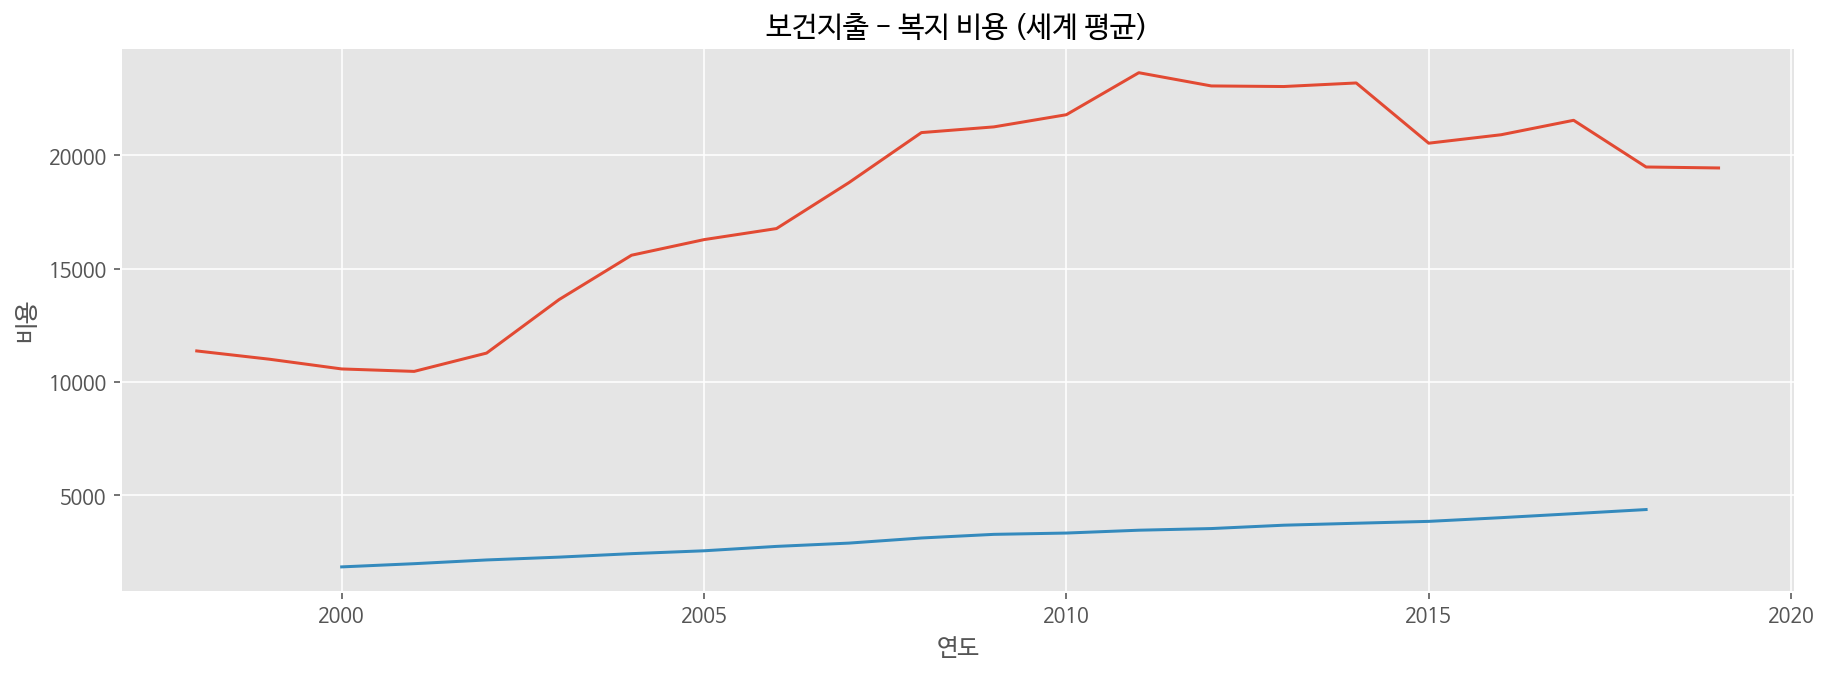

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax = sns.lineplot(data=df_corr, x="연도", y="평균 복지 비용(G$)", ci=None)
ax = sns.lineplot(data=df_corr, x="연도", y="1인당 보건지출", ci=None)
_ = ax.set_title("보건지출 - 복지 비용 (세계 평균)")
_ = ax.set_ylabel("비용")

In [51]:
df_corr["보건지출-복지비용 비율"] = df_corr["1인당 보건지출"]/df_corr["평균 복지 비용(G$)"]

In [52]:
px.area(data_frame=df_corr, x="연도", y="보건지출-복지비용 비율", color="국가", title="1인당 보건지출-복지비용 비율")

#### 보건 지출 대비 치료비

In [53]:
df_corr["보건지출-치료비 비율"] = df_corr["평균 치료비"] / df_corr["1인당 보건지출"]

In [54]:
px.area(data_frame=df_corr, x="연도", y="보건지출-치료비 비율", color="국가", title="1인당 보건지출-치료비 비율")

#### 보건 지출 대비 의약품 소비량

In [55]:
df_corr["보건지출-의약품 소비량 비율"] = df_corr["1인당 보건지출"] / df_corr["평균 소비량"]

In [56]:
px.area(data_frame=df_corr, x="연도", y="보건지출-의약품 소비량 비율", color="국가", title="보건지출-의약품 소비량 비율")

#### 의약품 판매량 대비 의약품 소비량

In [57]:
df_corr["의약품 판매량-의약품 소비량 비율"] = df_corr["평균 판매량"] / df_corr["평균 소비량"]

In [58]:
px.area(data_frame=df_corr, x="연도", y="의약품 판매량-의약품 소비량 비율", color="국가", title="의약품 판매량-의약품 소비량 비율")

#### 의료 인력 수 대비 평균 치료비

In [59]:
df_corr["의료 인력-평균 치료비 비율"] = df_corr["평균 치료비"] / df_corr["평균 의료 인력 수"]

In [60]:
px.area(data_frame=df_corr, x="연도", y="의료 인력-평균 치료비 비율", color="국가", title="의료 인력-평균 치료비 비율")

### 상관 계수 분석

#### 1. 28개국 전체 데이터 기준

In [61]:
df = df_corr[['국가', '연도', '평균 사망률', '평균 의료 인력 수', '1인당 보건지출', '평균 소비량', '평균 판매량', '평균 치료비', '평균 복지 비용(G$)']]

In [62]:
corr = df.corr()
corr

,연도,평균 사망률,평균 의료 인력 수,1인당 보건지출,평균 소비량,평균 판매량,평균 치료비,평균 복지 비용(G$)
연도,1.000000,-0.419451,0.137211,0.546067,0.430431,0.126220,0.113442,0.145934
평균 사망률,-0.419451,1.000000,-0.305054,-0.742939,-0.458375,-0.344344,-0.271593,-0.385051
평균 의료 인력 수,0.137211,-0.305054,1.000000,0.191464,0.106343,0.900279,0.646640,0.893769
1인당 보건지출,0.546067,-0.742939,0.191464,1.000000,0.410244,0.217899,0.164146,0.279299
평균 소비량,0.430431,-0.458375,0.106343,0.410244,1.000000,-0.023755,-0.051508,0.001107
평균 판매량,0.126220,-0.344344,0.900279,0.217899,-0.023755,1.000000,0.661818,0.953818
평균 치료비,0.113442,-0.271593,0.646640,0.164146,-0.051508,0.661818,1.000000,0.653461
평균 복지 비용(G$),0.145934,-0.385051,0.893769,0.279299,0.001107,0.953818,0.653461,1.000000


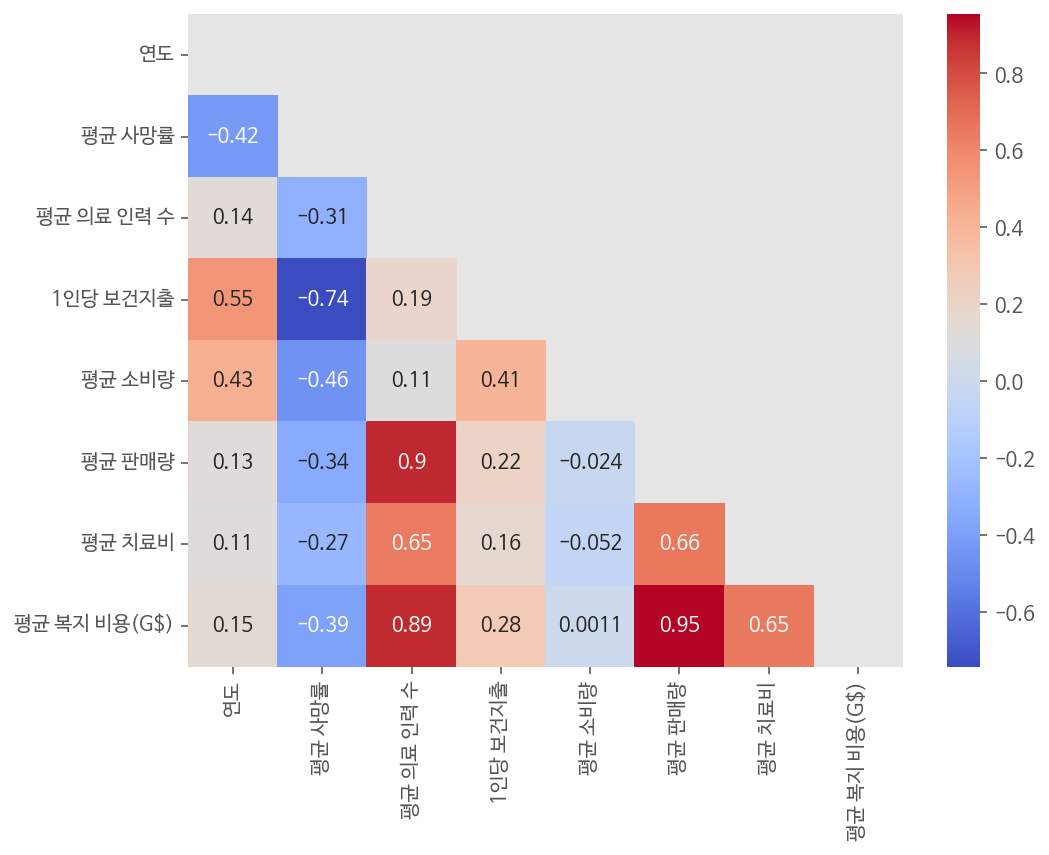

In [63]:
plt.figure(figsize=(8,6))
_ = sns.heatmap(data=corr, annot=True, cmap="coolwarm", mask=np.triu(np.ones_like(corr)))

주요 원인별 사망률과 의료 인프라 간의 상관계수는 음의 상관을 띄고 있습니다.  
즉, 의료 인프라와 관련된 변수의 값이 증가하면, 사망률은 감소한다는 것을 의미합니다.  
사망률과 가장 상관 관계가 큰 인프라는 **1인당 보건지출**입니다. 그 다음으로 의약품 소비량입니다.

#### 2. 한국 (2008-2019년) 데이터 기준

In [64]:
df_corr_kr = df_death_rate.loc[(df_death_rate['국가'] == '한국'), ['국가', '질병명', '연도', '성별', '사망률']].reset_index(drop = True)
df_corr_kr.head()

,국가,질병명,연도,성별,사망률
0,한국,특정감염성 및 기생충성질환,1998,남자,24.6
1,한국,특정감염성 및 기생충성질환,1998,여자,8.8
2,한국,호흡기결핵,1998,남자,15.8
3,한국,호흡기결핵,1998,여자,4.1
4,한국,악성신생물(암),1998,남자,196.2


##### 1) 국내 사망률 - 의약품 소비량 간 관계 분석 (DataFrame : df_kr_death_med)
###### 질병코드에 따라 아래 5개로 분류하여 상관관계 분석 후 시각화
###### '내분비/대사질환', '소화계통', '순환계통', '정신 및 행동장애', '그 외'
    * 분석 결론 1. 의약품 소비량이 증가하면 해당 질병에 기인한 사망률이 감소하는 경향을 보임

In [65]:
# 한국표준질병사인분류 코드에 따라, 데이터 셋 질병명 대분류 정리
# medicine : 호흡계통 데이터 없음 - 그 외로 분류
dict_disease_cat = {'특정감염성 및 기생충성질환': '그 외',
                    ' 호흡기결핵': '그 외',
                    '악성신생물(암)': '그 외',
                    ' 위': '소화계통',
                    ' 간 및 간내 쓸개관': '소화계통',
                    ' 기관·기관지 및 폐': '순환계통',
                    ' 유방': '그 외',
                    '당뇨병': '내분비/대사질환',
                    '순환기계통의 질환': '순환계통',
                    ' 고혈압성질환': '순환계통',
                    ' 허혈성심질환': '순환계통',
                    ' 뇌혈관질환': '순환계통',
                    '호흡기계통의 질환': '그 외',
                    '소화기계통의 질환': '소화계통',
                    ' 간질환': '소화계통',
                    '사망의 외부요인': '그 외',
                    ' 운수사고': '그 외',
                    ' 고의적 자해(자살)': '정신 및 행동장애'}
                    

In [66]:
# dict_disease_cat 기준 > 질병명 분류 컬럼 생성
for i in range(len(df_corr)):
    temp_name = df_corr_kr.iloc[i, 1]
    df_corr_kr.loc[i, '질병명_분류'] = dict_disease_cat[temp_name]

df_corr_kr.head(3)

,국가,질병명,연도,성별,사망률,질병명_분류
0,한국,특정감염성 및 기생충성질환,1998,남자,24.6,그 외
1,한국,특정감염성 및 기생충성질환,1998,여자,8.8,그 외
2,한국,호흡기결핵,1998,남자,15.8,그 외


In [67]:
# 한국에 대해서 - 2008년 이후부터 분석 (데이터가 그 때부터 생성되었음)
# 연도 별 
df_kr_death_med = pd.DataFrame(df_corr_kr[df_corr_kr['연도']>=2008].groupby(by = ['연도', '질병명_분류'], as_index = False)['사망률'].mean()).sort_values('사망률',  ascending = False).reset_index(drop = True)
df_kr_death_med.head(3)

,연도,질병명_분류,사망률
0,2016,순환계통,47.6600
1,2016,그 외,44.3375
2,2008,순환계통,43.0100


In [68]:
# 한국표준질병사인분류 코드에 따라, 데이터 셋 질병명 대분류 정리
# medicine : 호흡계통 데이터 없음 - 사망률 데이터에서도 '그 외'로 분류
dict_medicine_cat = {'소화관 및 신진대사': '소화계통',
                    '제산제': '소화계통',
                    '소화성궤양 및 위장용 약물': '소화계통',
                    '당뇨 약물': '내분비/대사질환',
                    '심장 배당체': '순환계통',
                    '항 부정맥제': '순환계통',
                    '이뇨제': '순환계통',
                    '향균제': '그 외',
                    '진통제': '그 외',
                    '수면제 및 진정제':'정신 및 행동장애' ,
                    '항우울제': '정신 및 행동장애'}

In [69]:
# dict_medicine_cat 기준 > 질병명 분류 컬럼 생성
for i in range(len(df_medicion)):
    temp_name = df_medicion.iloc[i, 2]
    df_medicion.loc[i, '질병명_분류'] = dict_medicine_cat[temp_name]

df_medicion.head(3)

,국가,연도,의약품,의약품소비량,의약품판매량,질병명_분류
0,한국,2008,소화관 및 신진대사,263.6,15821.1,소화계통
1,한국,2008,제산제,2.2,15821.1,소화계통
2,한국,2008,소화성궤양 및 위장용 약물,33.1,15821.1,소화계통


In [70]:
# 한국에 대해서 - 2008년 이후부터 분석 (데이터가 그 때부터 생성되었음)
# 연도 별 
df_temp = pd.DataFrame(df_medicion[df_medicion['국가']=='한국'].groupby(by = ['연도', '질병명_분류'], as_index = False)[['의약품소비량']].sum()).sort_values('의약품소비량',  ascending = False)
df_temp.head(3)

,연도,질병명_분류,의약품소비량
32,2014,소화계통,472.6
37,2015,소화계통,420.8
27,2013,소화계통,377.3


In [71]:
# merge 위한 key값 생성 후, null값 생성될 여지 없는지 여집합 이용해 확인
df_temp['key'] = df_temp['연도'].astype(str)+df_temp['질병명_분류']
df_kr_death_med['key'] = df_kr_death_med['연도'].astype(str)+df_kr_death_med['질병명_분류']
len(set(df_kr_death_med['key'].unique())-set(df_temp['key'].unique())), len(set(df_temp['key'].unique())-set(df_kr_death_med['key'].unique()))

(0, 16)

In [72]:
# 상관관계 분석 위한 dataframe 생성
df_kr_death_med = df_kr_death_med.merge(right = df_temp, on = 'key').drop(columns = ['key','연도_y','질병명_분류_y'], axis = 1)
df_kr_death_med.columns = ['연도','질병명_분류','사망률','의약품소비량']
df_kr_death_med.head()

,연도,질병명_분류,사망률,의약품소비량
0,2016,순환계통,47.6600,16.9
1,2016,그 외,44.3375,42.2
2,2008,순환계통,43.0100,22.6
3,2009,순환계통,39.7000,22.2
4,2010,순환계통,38.9600,21.3


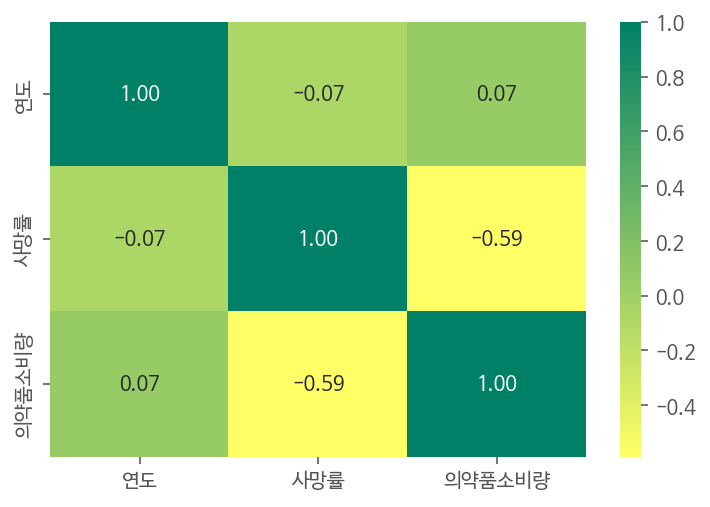

In [73]:
_ = sns.heatmap(df_kr_death_med.corr(), cmap = 'summer_r', annot = True, fmt = '.2f', )
# label = '질병 종류에 따른 사망률과 의약품 소비/판매량 간 상관관계 분석'

##### 2) 국내 사망률 - 의료 종사자 수 간 관계 분석 (DataFrame : df_kr_death_workers)
    * 치과의사/약사 : 해에 따른 변동이 거의 없으므로 제외
    * 의사/간호사 데이터만 이용

In [74]:
# 의약품 데이터가 아니므로, 굳이 2008년부터 볼 이유가 없다 : 전체 연도에 대해서 진행함
df_kr_death_workers = df_Nmw.loc[(df_Nmw['국가']=='한국') & (df_Nmw['직업'].isin(['의사','간호사'])),"연도":"수"].groupby(by = ['직업', '연도'], as_index = False)['수'].sum()
df_kr_death_workers.columns = ['직업', '연도', '종사자 수']
df_kr_death_workers.head(7)

,직업,연도,종사자 수
0,간호사,1998,128427.0
1,간호사,1999,135923.0
2,간호사,2000,140288.0
3,간호사,2001,151351.0
4,간호사,2002,163203.0
5,간호사,2003,169555.0
6,간호사,2004,182612.0


In [75]:
df_kr_death_workers = df_kr_death_workers.merge(right = df_corr_kr.groupby('연도', as_index = False)['사망률'].mean(), on = '연도')
df_kr_death_workers.head()

,직업,연도,종사자 수,사망률
0,간호사,1998,128427.0,45.262857
1,의사,1998,58684.0,45.262857
2,간호사,1999,135923.0,44.180000
3,의사,1999,61182.0,44.180000
4,간호사,2000,140288.0,44.602857


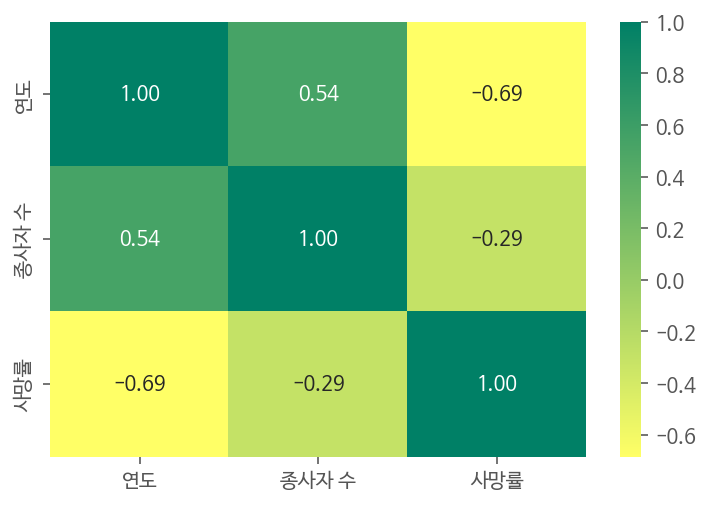

In [76]:
_ = sns.heatmap(df_kr_death_workers.corr(), cmap = 'summer_r', annot = True, fmt = '.2f', )
# label = '직업 별 의료 종사자 수와 사망률 간 상관관계 분석'
# 변동이 없는 '치과의사', '약사'를 포함했을 때, 결과가 흐려지는 걸 확인함
# 분석할 때 플러스마이너스요인을 잘 구별해내는 게 중요한 것 같음

##### 3) 국내 사망률 - 보건 관련 지출 간 관계 분석 (DataFrame : df_kr_death_service)

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
# GDP 데이터 다시 불러옴
df_gdp = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OECD_국가의_주요지표_20220610085126.csv", encoding = 'cp949')[['시점','국가별(2)', '데이터']]
df_gdp = df_gdp[df_gdp['국가별(2)']=='한국']
df_gdp.columns = ['연도','국가', 'GDP(10억$)']
df_gdp['key'] = df_gdp['연도'].astype(str)+df_gdp['국가']
df_gdp.head()

,연도,국가,GDP(10억$),key
0,1998,한국,384.0,1998한국
38,1999,한국,497.2,1999한국
76,2000,한국,576.4,2000한국
114,2001,한국,547.7,2001한국
152,2002,한국,627.2,2002한국


In [79]:
df_service['key'] = df_service['연도'].astype(str)+df_service['국가별']
df_service = df_service.merge(right = df_gdp[['GDP(10억$)', 'key']], on = 'key')
df_service.head()

,국가별,항목,데이터값,연도,국가영문,key,GDP(10억$)
0,한국,경상(GDP 대비%),3.897594,2000,South Korea,2000한국,576.4
1,한국,공공(경상보건비 대비%),50.327538,2000,South Korea,2000한국,576.4
2,한국,본인부담(경상보건비 대비%),43.638454,2000,South Korea,2000한국,576.4
3,한국,1인당 보건지출(US$),473.986755,2000,South Korea,2000한국,576.4
4,한국,1인당 보건지출(PPP)(US$),717.389038,2000,South Korea,2000한국,576.4


In [80]:
df_service = df_service.drop(['연도', '국가영문', '국가별'], axis = 1)
df_service.head()

,항목,데이터값,key,GDP(10억$)
0,경상(GDP 대비%),3.897594,2000한국,576.4
1,공공(경상보건비 대비%),50.327538,2000한국,576.4
2,본인부담(경상보건비 대비%),43.638454,2000한국,576.4
3,1인당 보건지출(US$),473.986755,2000한국,576.4
4,1인당 보건지출(PPP)(US$),717.389038,2000한국,576.4


In [81]:
# 한국에 대해서 - 2008년 이후부터 분석 (데이터가 그 때부터 생성되었음)
# 연도 별 
df_kr_death_service_temp = pd.DataFrame(df_corr_kr[df_corr_kr['연도']>=2008].groupby(by = '연도', as_index = False)['사망률'].mean()).sort_values('사망률',  ascending = False).reset_index(drop = True)
df_kr_death_service_temp.head(3)

,연도,사망률
0,2018,37.577778
1,2019,36.863889
2,2017,36.583333


In [82]:
df_service_temp = df_service[df_service['항목'].isin(['1인당 보건지출(US$)', '1인당 보건지출(PPP)(US$)'])]
df_service_temp.head(4)

,항목,데이터값,key,GDP(10억$)
3,1인당 보건지출(US$),473.986755,2000한국,576.4
4,1인당 보건지출(PPP)(US$),717.389038,2000한국,576.4
9,1인당 보건지출(US$),508.280762,2001한국,547.7
10,1인당 보건지출(PPP)(US$),865.809143,2001한국,547.7


In [83]:
df_service_temp['key'] = df_service_temp['key'].astype(str).str[:4]
df_service_temp.columns = ['항목', '데이터값', '연도', 'GDP(10억$)']
df_service_temp.head(4)

,항목,데이터값,연도,GDP(10억$)
3,1인당 보건지출(US$),473.986755,2000,576.4
4,1인당 보건지출(PPP)(US$),717.389038,2000,576.4
9,1인당 보건지출(US$),508.280762,2001,547.7
10,1인당 보건지출(PPP)(US$),865.809143,2001,547.7


In [84]:
df_service_temp['연도'] = df_service_temp['연도'].astype(int)
df_service_temp.head(4)

,항목,데이터값,연도,GDP(10억$)
3,1인당 보건지출(US$),473.986755,2000,576.4
4,1인당 보건지출(PPP)(US$),717.389038,2000,576.4
9,1인당 보건지출(US$),508.280762,2001,547.7
10,1인당 보건지출(PPP)(US$),865.809143,2001,547.7


In [85]:
df_service_temp.dtypes

항목            object
데이터값         float64
연도             int64
GDP(10억$)    float64
dtype: object

In [86]:
df_kr_death_service_temp.dtypes

연도       int64
사망률    float64
dtype: object

In [87]:
df_kr_death_service = df_service_temp[df_service_temp['연도']>=2008].merge(right =df_kr_death_service_temp, how = 'left', on = '연도' )
df_kr_death_service.head()

,항목,데이터값,연도,GDP(10억$),사망률
0,1인당 보건지출(US$),1149.708618,2008,1046.8,32.968571
1,1인당 보건지출(PPP)(US$),1612.579590,2008,1046.8,32.968571
2,1인당 보건지출(US$),1106.064087,2009,944.3,31.731429
3,1인당 보건지출(PPP)(US$),1712.750488,2009,944.3,31.731429
4,1인당 보건지출(US$),1366.384399,2010,1143.9,31.257143


In [88]:
df_kr_death_service = df_kr_death_service.groupby(by = ['항목','연도'], as_index = False)[['데이터값', '사망률']].agg(['sum', 'mean'])
df_kr_death_service.head()

데이터값                     사망률           
                                 sum         mean        sum       mean
항목                 연도                                                  
1인당 보건지출(PPP)(US$) 2008  1612.579590  1612.579590  32.968571  32.968571
                   2009  1712.750488  1712.750488  31.731429  31.731429
                   2010  1878.513550  1878.513550  31.257143  31.257143
                   2011  1961.464111  1961.464111  30.031429  30.031429
                   2012  2063.654053  2063.654053  29.360000  29.360000

In [89]:
df_kr_death_service = df_kr_death_service.iloc[:,[0,3]].reset_index(drop = False)
df_kr_death_service.info

<bound method DataFrame.info of                     항목    연도         데이터값        사망률
                                      sum       mean
0   1인당 보건지출(PPP)(US$)  2008  1612.579590  32.968571
1   1인당 보건지출(PPP)(US$)  2009  1712.750488  31.731429
2   1인당 보건지출(PPP)(US$)  2010  1878.513550  31.257143
3   1인당 보건지출(PPP)(US$)  2011  1961.464111  30.031429
4   1인당 보건지출(PPP)(US$)  2012  2063.654053  29.360000
5   1인당 보건지출(PPP)(US$)  2013  2143.083252  27.617143
6   1인당 보건지출(PPP)(US$)  2014  2293.312988  26.445714
7   1인당 보건지출(PPP)(US$)  2015  2531.398438  25.614286
8   1인당 보건지출(PPP)(US$)  2016  2748.367920  36.533333
9   1인당 보건지출(PPP)(US$)  2017  2929.065674  36.583333
10  1인당 보건지출(PPP)(US$)  2018  3213.663330  37.577778
11       1인당 보건지출(US$)  2008  1149.708618  32.968571
12       1인당 보건지출(US$)  2009  1106.064087  31.731429
13       1인당 보건지출(US$)  2010  1366.384399  31.257143
14       1인당 보건지출(US$)  2011  1512.452515  30.031429
15       1인당 보건지출(US$)  2012  1566.122803  29.360000
16       1인당 보

In [91]:
df_kr_death_service.head()

,항목,연도,데이터값,사망률
,,,sum,mean
0,1인당 보건지출(PPP)(US$),2008,1612.579590,32.968571
1,1인당 보건지출(PPP)(US$),2009,1712.750488,31.731429
2,1인당 보건지출(PPP)(US$),2010,1878.513550,31.257143
3,1인당 보건지출(PPP)(US$),2011,1961.464111,30.031429
4,1인당 보건지출(PPP)(US$),2012,2063.654053,29.360000


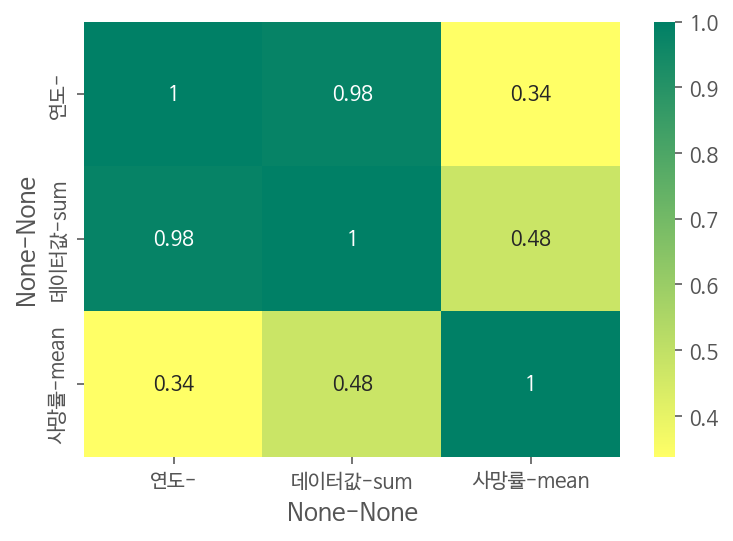

In [92]:
# 1인당 보건지출(PPP)(US$)
_ = sns.heatmap(df_kr_death_service[df_kr_death_service['항목'] =='1인당 보건지출(PPP)(US$)'].corr(), cmap = 'summer_r', annot = True)

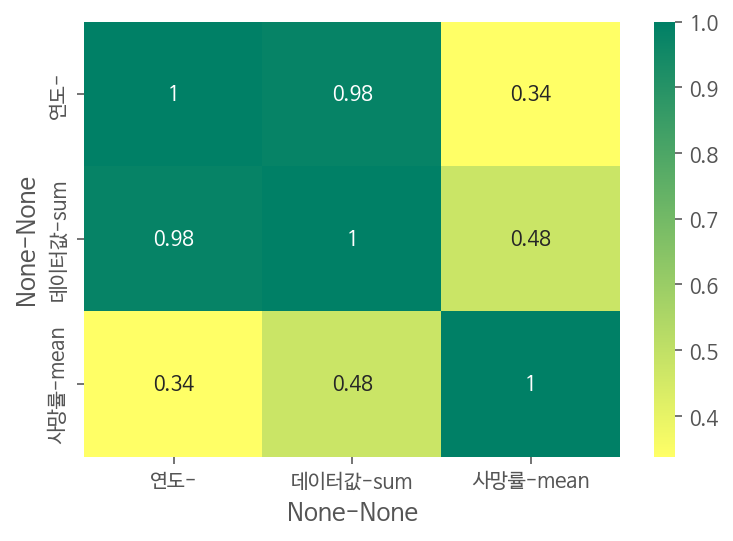

In [93]:
# 1인당 보건지출(US$)
_ = sns.heatmap(df_kr_death_service[df_kr_death_service['항목'] =='1인당 보건지출(PPP)(US$)'].corr(), cmap = 'summer_r', annot = True)

##### 4) 국내 사망률 - 보건 서비스 지출 간 관계 분석 (DataFrame : df_kr_death_service_common)

In [94]:
df_temp_corr = df_corr_kr.groupby('연도', as_index = False)[['사망률']].mean()
df_temp_corr.head()

,연도,사망률
0,1998,45.262857
1,1999,44.180000
2,2000,44.602857
3,2001,43.317143
4,2002,43.951429


In [95]:
target_list = ['치료 및 재활 치료', '장기 치료', '예방치료']
df_kr_death_service_common = df_service_common.loc[(df_service_common['국가']=='한국')&(df_service_common['항목구분'].isin(target_list)), ['연도', '서비스비용(백만$)']].groupby('연도', as_index = False).sum().reset_index(drop = True)
df_kr_death_service_common.head()

,연도,서비스비용(백만$)
0,1998,9625.87
1,1999,13282.96
2,2000,15169.17
3,2001,15916.90
4,2002,16907.84


In [96]:
df_kr_death_service_common = df_kr_death_service_common.merge(right = df_temp_corr, on = '연도')
df_kr_death_service_common.head(10)

,연도,서비스비용(백만$),사망률
0,1998,9625.87,45.262857
1,1999,13282.96,44.180000
2,2000,15169.17,44.602857
3,2001,15916.90,43.317143
4,2002,16907.84,43.951429
5,2003,19858.32,41.951429
6,2004,22338.66,39.471429
7,2005,28083.67,37.502857
8,2006,33957.33,35.597143
9,2007,39580.19,34.854286


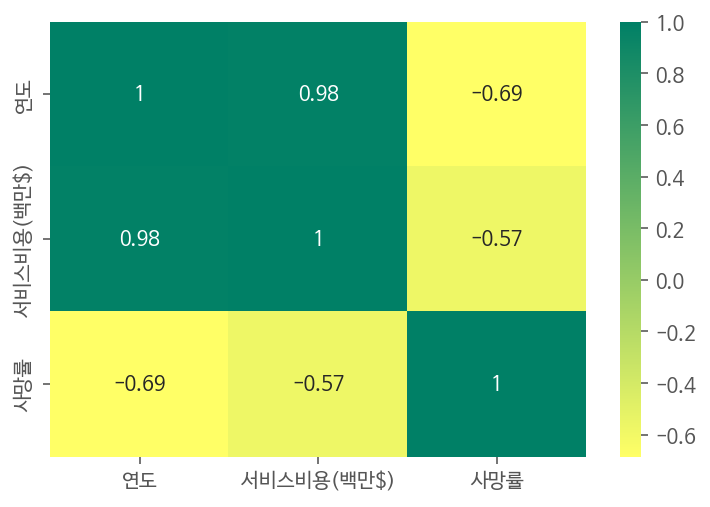

In [97]:
sns.heatmap(df_kr_death_service_common.corr(), cmap = 'summer_r', annot = True)

## 5. 최종 결론 및 한계점
## 이거 제가 노션 정리하면서 같이 적을게요! 물론 원하시면 적어주셔도 좋습니다!